In [1]:
from fit import *
import matplotlib.pyplot as plt
%matplotlib widget
from utils import plot_event, plot_generator, get_data_files, preceding_noise_files
from counter_config import CounterConfig, init_config

First set up the MC configuration, i.e. the data part for which we're simulating data.

In [2]:
# data_date_and_time = '20190504034237'
# data_files = get_data_files(data_date_and_time)
# noise_files = [preceding_noise_file(f) for f in data_files]
# cfg = CounterConfig(data_files, noise_files)
data_date_and_time = '20230618050455'
cfg = init_config(data_date_and_time)
ckv = GetCkv(cfg)

Now let's simulate an event with given shower parameters.

In [3]:
# pars = [6.479052e+02,1.705156e+06,5.890362e-01,2.461860e+00, 437., -660.,-29.0,0,70,0.]
pars = [650.,6.e6,np.deg2rad(40.),np.deg2rad(90.), 450., -660.,-29,0,70,0.]
ev = BasicParams.get_event(pars)
pe = ProcessEvents(cfg, frozen_noise=True)
real_nfits = pe.gen_nfits_from_event(ev)
print(ev)

Event(E=4615384615384615.0, Xmax=650.0, Nmax=6000000.0, zenith=0.6981317007977318, azimuth=1.5707963267948966, corex=450.0, corey=-660.0, corez=-29, X0=0, Lambda=70)


We now have fitted NICHE waveforms, so we can estimate the core position with a tyro fit, and perform a plane fit to estimate the shower direction. We then compile this info into inital guesses to supply to the minimizer.

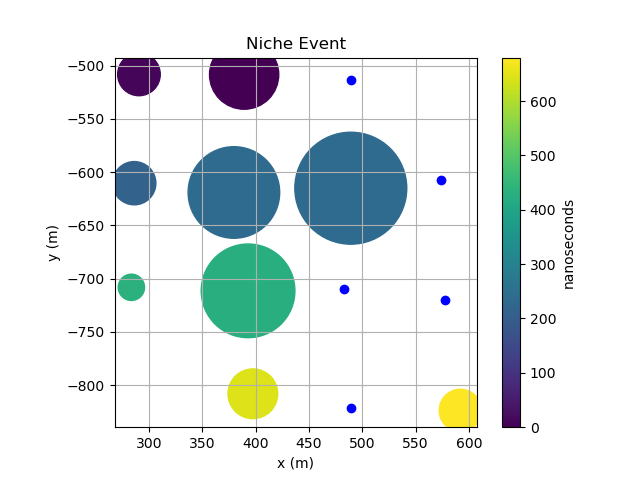

In [4]:
ty = tyro(real_nfits)
pf = NichePlane(real_nfits)
plot_event(ty)

In [5]:
pf

20240817191419.000025510
bardeen bell curie newton noether rossi rubin rutherford wu 
nx = -0.0229 ny =  0.6368 z0 =   1.6
  +/- 0.0001   +/- 0.0001   +/-  0.0
  ( 7.96e-09 -2.96e-09 -3.59e-07)
  (-2.96e-09  7.30e-09  7.05e-08)
  (-3.59e-07  7.05e-08  3.71e-05)
th =  0.6909 ph =  1.6068

In [6]:
guess = make_guess(ty, pf,cfg)
# for i,p in enumerate(guess):
#     guess[i].value = pars[i]
[print(p) for p in guess];

FitParam(name='xmax', value=500.0, limits=(400.0, 800.0), error=50.0, fixed=False)
FitParam(name='nmax', value=1000000.0, limits=(10000.0, 100000000.0), error=100000.0, fixed=False)
FitParam(name='zenith', value=0.6908784302379855, limits=(0.0, 0.7908784302379854), error=0.017453292519943295, fixed=False)
FitParam(name='azimuth', value=1.6067836054458138, limits=(1.5067836054458137, 1.7067836054458139), error=0.017453292519943295, fixed=False)
FitParam(name='corex', value=424.0832440780499, limits=(379.5, 489.2), error=5.0, fixed=False)
FitParam(name='corey', value=-625.7674742458115, limits=(-711.4, -508.5), error=5.0, fixed=False)
FitParam(name='corez', value=-29.0, limits=(-29.0, -29.0), error=1.0, fixed=True)
FitParam(name='x0', value=0.0, limits=(0, 0), error=1, fixed=True)
FitParam(name='lambda', value=70.0, limits=(60.0, 80.0), error=1, fixed=True)
FitParam(name='t_offset', value=0.0, limits=(-450.0, 450.0), error=10.0, fixed=False)


Fitting for the log of xmax and nmax rather than the values themselves results in a better fit, so we use the BasicParams mapper to go between the fitted parameters and the real ones.

In [7]:
guess = BasicParams.adjust_guess(guess)
# guess = pars

Now we can begin the fit procedure, starting by fitting the peaktimes for the shower angles.

Now with a good estimate for the angles, we can fit the pulse widths to estimate xmax.

In [8]:
pt = PeakTimes(real_nfits, BasicParams, cfg)
pt.target_parameters = ['zenith','azimuth']
m = init_minuit(pt, guess)
m.simplex(ncall=40)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 256.6 (χ²/ndof = 36.7)     │              Nfcn = 42               │
│ EDM = 10.7 (Goal: 0.1)           │           time = 22.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    500    │    50     │            │            │   400   │   800   │  yes  │
│ 1 │ nmax     │   1.0e6   │   0.1e6   │            │            │  10000  │  1e+08  │  yes  │
│ 2 │ zenith   │ 694.69e-3 │  0.18e-3  │            │            │    0    │0.790878 │       │
│ 3 │ azimuth  │  1.56213  │  0.00026  │            │            │ 1.50678 │ 1.70678 │       │
│ 4 │ corex    │    424    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │   -626    │     5     │            │            │ -711.4  │ -508.5  │  yes  │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │   60    │   80    │  yes  │
│ 9 │ t_offset │     0     │    10     │            │            │  -450   │   450   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [9]:
# tpguess = update_guess(m)
# pw = PulseWidth(real_nfits, BasicParams, cfg)
# pw.target_parameters = ['xmax']
# m = init_minuit(pw, tpguess)
# m.simplex(ncall=40)

Now, with a good estimate for log(xmax), we can fit the integrated pulse areas for nmax.

In [10]:
# xmaxguess = update_guess(m)
# pa = PulseArea(real_nfits, BasicParams, cfg)
# pa.target_parameters = ['nmax']
# m = init_minuit(pa, xmaxguess)
# m.simplex(ncall=20)

Now, with these values in the ballpark, we can simultaneously minimize both the shower profile and core position by fitting the normalized pulse areas.

In [11]:
nmaxguess = update_guess(m)
pa = NormalizedPulseArea(real_nfits, BasicParams, cfg)
pa.target_parameters = ['xmax','nmax','corex','corey']
m = init_minuit(pa, nmaxguess)
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1043 (χ²/ndof = 208.5)     │              Nfcn = 151              │
│ EDM = 11.7 (Goal: 0.1)           │           time = 67.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    668    │     5     │            │            │   400   │   800   │       │
│ 1 │ nmax     │  5.28e6   │  0.08e6   │            │            │  10000  │  1e+08  │       │
│ 2 │ zenith   │ 694.69e-3 │  0.18e-3  │            │            │    0    │0.790878 │  yes  │
│ 3 │ azimuth  │  1.56213  │  0.00026  │            │            │ 1.50678 │ 1.70678 │  yes  │
│ 4 │ corex    │   450.3   │    0.9    │            │            │  379.5  │  489.2  │       │
│ 5 │ corey    │  -694.3   │    0.7    │            │            │ -711.4  │ -508.5  │       │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │   60    │   80    │  yes  │
│ 9 │ t_offset │     0     │    10     │            │            │  -450   │   450   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [12]:
# nmaxguess = update_guess(m)
# pa = NormalizedPulseArea(real_nfits, BasicParams, cfg)
# pa.target_parameters = ['corex','corey']
# m = init_minuit(pa, nmaxguess)
# m.scan()

Now that we're reasonably close to the minimum, we can zero in on it by freeing all the parameters simultaneously.

In [13]:
# guess = update_guess(m)
# at = AllTunka(real_nfits, BasicParams, cfg)
# at.target_parameters = ['t_offset']
# m = init_minuit(at, guess)
# m.migrad()

In [14]:
# m.tol=.01
# m.fixed = True
# m.fixed['xmax'] = False
# m.fixed['nmax'] = False
# m.fixed['zenith'] = False
# m.fixed['azimuth'] = False
# m.fixed['corex'] = False
# m.fixed['corey'] = False
# m.fixed['t_offset'] = False
# # m.scan()
# m.simplex()

In [15]:
guess = update_guess(m)
at = AllSamples(real_nfits, BasicParams, cfg)
at.target_parameters = ['t_offset']
m = init_minuit(at, guess)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.792e+04 (χ²/ndof = 1152.0)│              Nfcn = 77               │
│ EDM = 0.351 (Goal: 0.0002)       │           time = 30.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    668    │     5     │            │            │   400   │   800   │  yes  │
│ 1 │ nmax     │  5.28e6   │  0.08e6   │            │            │  10000  │  1e+08  │  yes  │
│ 2 │ zenith   │ 694.69e-3 │  0.18e-3  │            │            │    0    │0.790878 │  yes  │
│ 3 │ azimuth  │  1.56213  │  0.00026  │            │            │ 1.50678 │ 1.70678 │  yes  │
│ 4 │ corex    │   450.3   │    0.9    │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │  -694.3   │    0.7    │            │            │ -711.4  │ -508.5  │  yes  │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │   60    │   80    │  yes  │
│ 9 │ t_offset │122.337385 │ 0.000028  │            │            │  -450   │   450   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│          │     xmax     nmax   zenith  azimuth    corex    corey    corez       x0   lambda t_offset │
├──────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│     xmax │        0        0        0        0        0        0        0        0        0        0 │
│     nmax │        0        0        0        0        0        0        0        0        0        0 │
│   zenith │        0        0        0        0        0        0        0        0        0        0 │
│  azimuth │        0        0        0        0        0        0        0        0        0        0 │
│    corex │        0        0        0        0        0        0        0        0        0        0 │
│    corey │        0        0        0        0        0        0        0        0        0        0 │
│    corez │        0        0        0        0        0        0        0        0        0        0 │
│       x0 │        0        0        0        0        0        0        0        0        0        0 │
│   lambda │        0        0        0        0        0        0        0        0        0        0 │
│ t_offset │        0        0        0        0        0        0        0        0        0 8.11e-10 │
└──────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [16]:
# m.tol=.01
# m.fixed = True
# # m.fixed['xmax'] = False
# # m.fixed['nmax'] = False
# # m.fixed['zenith'] = False
# # m.fixed['azimuth'] = False
# m.fixed['corex'] = False
# m.fixed['corey'] = False
# m.fixed['t_offset'] = False
# # m.scan()
# m.simplex()

In [17]:
m.tol=.01
m.fixed = True
m.fixed['xmax'] = False
m.fixed['nmax'] = False
m.fixed['zenith'] = False
m.fixed['azimuth'] = False
# m.fixed['corex'] = False
# m.fixed['corey'] = False
m.fixed['t_offset'] = False
# m.scan()
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.132e+04 (χ²/ndof = 757.0)│              Nfcn = 201              │
│ EDM = 25.6 (Goal: 0.01)          │           time = 20.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │   625.7   │    1.0    │            │            │   400   │   800   │       │
│ 1 │ nmax     │  6.778e6  │  0.023e6  │            │            │  10000  │  1e+08  │       │
│ 2 │ zenith   │700.453e-3 │ 0.033e-3  │            │            │    0    │0.790878 │       │
│ 3 │ azimuth  │ 1.564893  │ 0.000027  │            │            │ 1.50678 │ 1.70678 │       │
│ 4 │ corex    │   450.3   │    0.9    │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │  -694.3   │    0.7    │            │            │ -711.4  │ -508.5  │  yes  │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │   60    │   80    │  yes  │
│ 9 │ t_offset │ 122.32706 │  0.00016  │            │            │  -450   │   450   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [18]:
# m.limits['xmax'] = (m.params['xmax'].value-20.,m.params['xmax'].value+20.)
# m.limits['nmax'] = (m.params['nmax'].value-2.e5,m.params['nmax'].value+2.e5)
# m.limits['zenith'] = (m.params['zenith'].value-5.e-2,m.params['zenith'].value+5.e-2)
# m.limits['azimuth'] = (m.params['azimuth'].value-5.e-2,m.params['azimuth'].value+5.e-2)
# m.limits['corex'] = (m.params['corex'].value-5.,m.params['corex'].value+5.)
# m.limits['corey'] = (m.params['corey'].value-5.,m.params['corey'].value+5.)
# m.limits['t_offset'] = (m.params['t_offset'].value-5.,m.params['t_offset'].value+5.)
# m.fixed = True
# m.fixed['xmax'] = False
# m.fixed['nmax'] = False
# m.fixed['zenith'] = False
# m.fixed['azimuth'] = False
# m.fixed['corex'] = False
# m.fixed['corey'] = False
# m.tol=1

In [19]:
# for par in guess:
#     m.errors[par.name] = par.error

In [20]:
fitpars = [p.value for p in m.params]
fit_ev = BasicParams.get_event(fitpars)
print(fit_ev)

Event(E=5213572825807283.0, Xmax=625.7119968609587, Nmax=6777644.673549468, zenith=0.7004529102452327, azimuth=1.5648932567475635, corex=450.25472460847425, corey=-694.3140854480622, corez=-29.0, X0=0.0, Lambda=70.0)


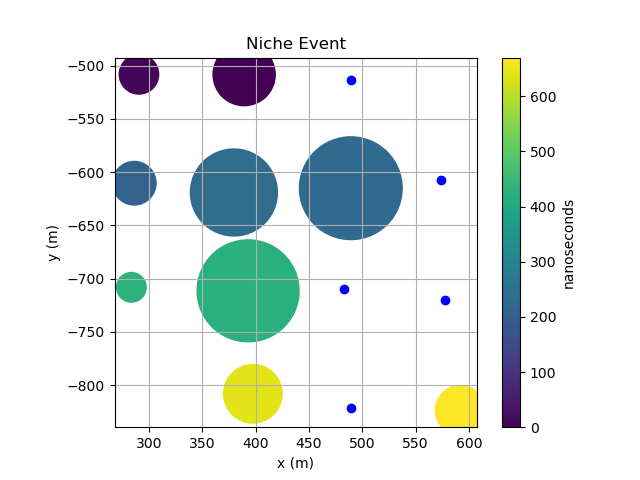

In [21]:
fit_nfits = pe.gen_nfits_from_event(fit_ev)
plot_event(tyro(fit_nfits))

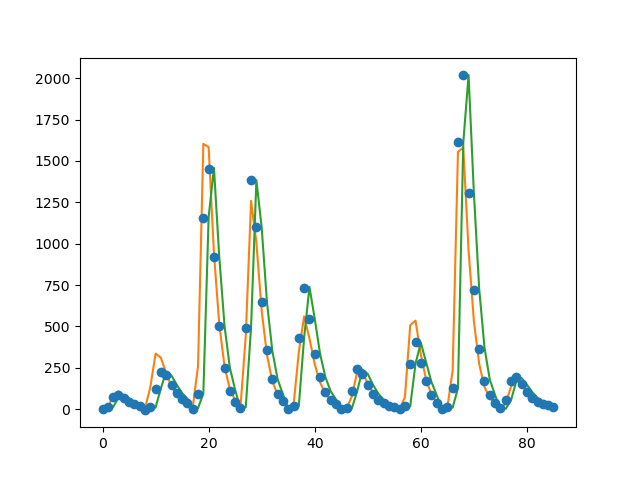

In [22]:
# at = AllTunka(real_nfits, BasicParams, cfg)
plt.figure()
plt.errorbar(np.arange(len(at.real_values)),at.real_values,yerr=at.error, fmt="o")
plt.plot(at.get_output(fitpars))
pars[-1] = 55.
plt.plot(at.get_output(pars))
# plt.semilogy()

In [23]:
pars[-1] = 55
at.chi2(pars)/m.ndof

5770.630567661906

In [24]:
pars

[650.0,
 6000000.0,
 0.6981317007977318,
 1.5707963267948966,
 450.0,
 -660.0,
 -29,
 0,
 70,
 55]

In [25]:
at.error

array([1.79546196, 1.79546196, 1.79546196, 1.79546196, 1.79546196,
       1.79546196, 1.79546196, 1.79546196, 3.77491794, 3.77491794,
       3.77491794, 3.77491794, 3.77491794, 3.77491794, 3.77491794,
       3.77491794, 3.77491794, 3.93603425, 3.93603425, 3.93603425,
       3.93603425, 3.93603425, 3.93603425, 3.93603425, 3.93603425,
       3.93603425, 4.02848392, 4.02848392, 4.02848392, 4.02848392,
       4.02848392, 4.02848392, 4.02848392, 4.02848392, 4.02848392,
       3.83103335, 3.83103335, 3.83103335, 3.83103335, 3.83103335,
       3.83103335, 3.83103335, 3.83103335, 3.83103335, 3.83103335,
       2.74903343, 2.74903343, 2.74903343, 2.74903343, 2.74903343,
       2.74903343, 2.74903343, 2.74903343, 2.74903343, 2.74903343,
       2.74903343, 2.62698294, 2.62698294, 2.62698294, 2.62698294,
       2.62698294, 2.62698294, 2.62698294, 2.62698294, 4.0251738 ,
       4.0251738 , 4.0251738 , 4.0251738 , 4.0251738 , 4.0251738 ,
       4.0251738 , 4.0251738 , 4.0251738 , 4.0251738 , 4.02517

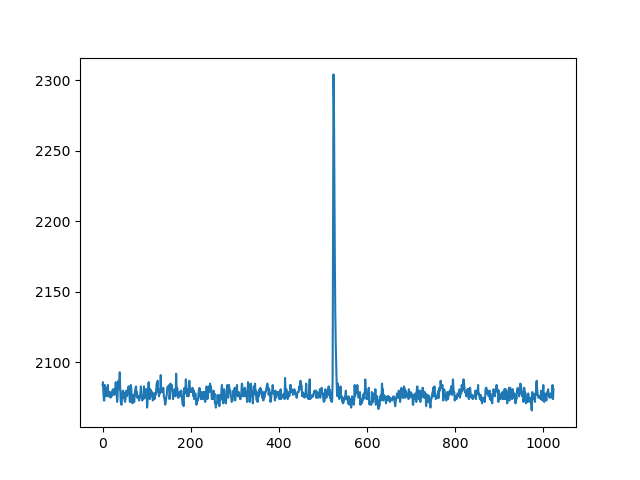

In [26]:
plt.figure()
plt.plot(real_nfits[1].waveform)

In [27]:
cfg.noise_open_files

[PosixPath('/home/isaac/niche_data/20230618/bardeen/20230618050431.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/bell/20230618050431.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/curie/20230618050431.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/feynman/20230618050431.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/newton/20230618050432.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/noether/20230618050431.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/rossi/20230618050431.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/rubin/20230618050431.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/rutherford/20230618050431.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/wu/20230618050431.bg.bin')]

In [28]:
cfg.noise_closed_files

[PosixPath('/home/isaac/niche_data/20230618/bardeen/20230618050345.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/bell/20230618050344.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/curie/20230618050344.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/feynman/20230618050344.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/newton/20230618050344.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/noether/20230618050344.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/rossi/20230618050344.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/rubin/20230618050344.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/rutherford/20230618050344.bg.bin'),
 PosixPath('/home/isaac/niche_data/20230618/wu/20230618050344.bg.bin')]

In [29]:
real_nfits[0].name

'bardeen'